# Ames房價預測

Author: 柯則宇  
Date: 17/12/16
* 認識資料
  1. 透過常理來猜測特徵與房價之間的關係
  2. 透過統計量來找出是否有漏掉的重要特徵，並使用圖表來增加可讀性
* 特徵工程
  1. 極端值處理
  2. 遺漏值差補
  3. 創建新特徵
  4. 類別型特徵one hot encoding
  5. 連續型特徵log轉換
* 建模
  1. RandomForest
  2. xgboost
  3. Lasso

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix
import time

In [72]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV
import xgboost as xgb

In [3]:
training = pd.read_csv("D:/GitHub/learning-kaggle/housePrice/train.csv")
testing = pd.read_csv("D:/GitHub/learning-kaggle/housePrice/test.csv")

## 1. 探索資料

再拿到資料的第一步要做的就是探索整份資料，花點時間對資料進行表面的探索對後面的處理絕對有幫助。透過`pandas.DataFrame.info`就能簡單的看出數據的一些端倪。包含了資料有多少筆觀察值、多少特徵，以及每個欄位特徵的相關資訊，像是有無missing value以及型態。

In [4]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

在上面的訊息中，可以先知道在Ames的房價測試資料中，有1460筆觀察值，81個特徵(包含一個目標變數SalePrice)，在這些特徵當中有3欄的float，35欄的int以及43欄的string，而且資料並不乾淨，有遺漏值，之後必須處理。  
並且我們可以從特徵的名字看出該房屋的資訊，在這些特徵中，可以簡單的分成幾類，包含房屋的空間面積，像是'TotalBsmtSF'，'GarageArea'；房屋的位置資訊，像是'Neighborhood'，'Street'；房屋的品質狀況，像是'OverallCond'，'GarageCond'；以及房屋的銷售資訊，像是'SalePrice'，'YrSold'。這些分類可以幫助我們快速理解手上這筆資料的"長相"。我們也可以發揮一些想像，當人們在買房子時，那些訊息是會被列入考量，進而影響房價的。  
在我的猜想中，居住面積('GrLivArea')、屋齡('YearBuilt')、房屋品質('OverallQual')以及房屋所在地('Neighborhood')將會是影響房價的重要因子。

在進行資料的表面探索後，接下來我們將對資料進行內部的數值探索，再透過一些統計上的數字分析以及視覺化可以幫助我們更清楚的劃出資料的輪廓。  
首先我們將先觀察所有連續變項兩兩之間的關聯性，皮爾森相關係數搭配`seaborn.heatmap`可以輕鬆地完成這件事。當顏色越深代表兩變項之間的關聯越強，藍色為正相關，紅色則是負相關。

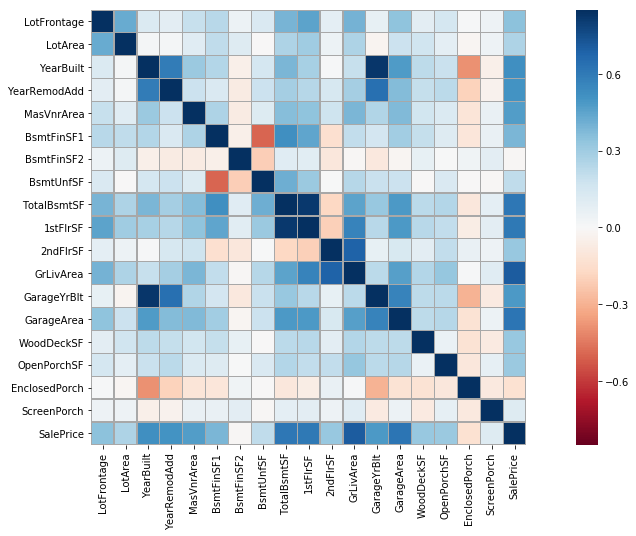

In [5]:
target = training.nunique()[training.nunique()>30].index  # 篩選屬於連續變項的特徵
corr_coef = training[target].drop('Id',axis=1).corr()
plt.figure(figsize=(18,8))
sns.heatmap(corr_coef, square=True, cmap='RdBu', vmin=-0.85, vmax=0.85, linewidths=0.3, linecolor='88')
plt.show()

透過heatmat可以快速看出房價('SalePrice')和所有連續變項的關聯性強度，房價('SalePrice')在與居住面積('GrLivArea')和房屋建造年份('YearBuilt')的確有著一定程度的正相關，但仍有其他不少的變項應該也要被納入考量。若沒有透過統計檢定，這些資訊將被忽略掉。  
其次，可以看到其他具有深色的地方，總地下室面積('TotalBsmtSF')和一樓面積('1stFirSF')具有高度關聯，房屋建造年份('YearBuilt')和車庫建造年份('GarageYrBlt')也是高度正相關。heatmap可以清楚的呈現這些狀況，而這些狀況告訴我們需要考慮共線性問題，這代表了這些變項給出了幾乎相同的訊息，之後在分析時，可能只需要保留這些有高度關聯變項的其中之一。  
再來我們將針對房價('SalePrice')和重要的預測變項來進行分析。

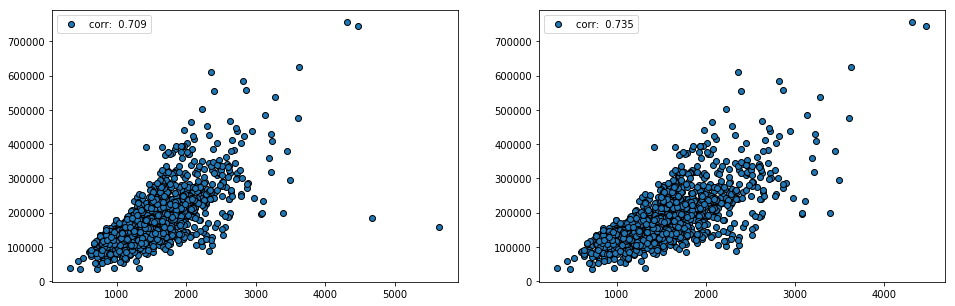

In [6]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.scatter(training['GrLivArea'], training['SalePrice'], edgecolors='k')
plt.legend(['corr: % .3f' % np.corrcoef(training['GrLivArea'], training['SalePrice'])[0,1]], loc='upper left')

# 刪除離群值
training = training.drop(training[(training['GrLivArea']>4000) & (training['SalePrice']<600000)].index)

plt.subplot(1,2,2)
plt.scatter(training['GrLivArea'], training['SalePrice'], edgecolors='k')
plt.legend(['corr: % .3f' % np.corrcoef(training['GrLivArea'], training['SalePrice'])[0,1]], loc='upper left')
plt.show()

在上面的散佈圖可以看到房價('SalePrice')和居住面積('GrLivArea')呈現一個左下右上的正相關，他們的相關係數高達0.709，這代表房子越大，房價也越貴。然而我們可以在右下角的部份看到兩個距離主群體較遠的點，他們擁有很大的居住面積，但房價卻是相對低的，因此我把它判定為outlier，並將他們從數據中刪除。此外，在右上角也有兩個居住面積較大，離主群體較遠的兩個點，但他們也擁有較高的房價，也就是說，他們仍在高居住面積高房價的趨勢上，基於這點，我們將不刪除。

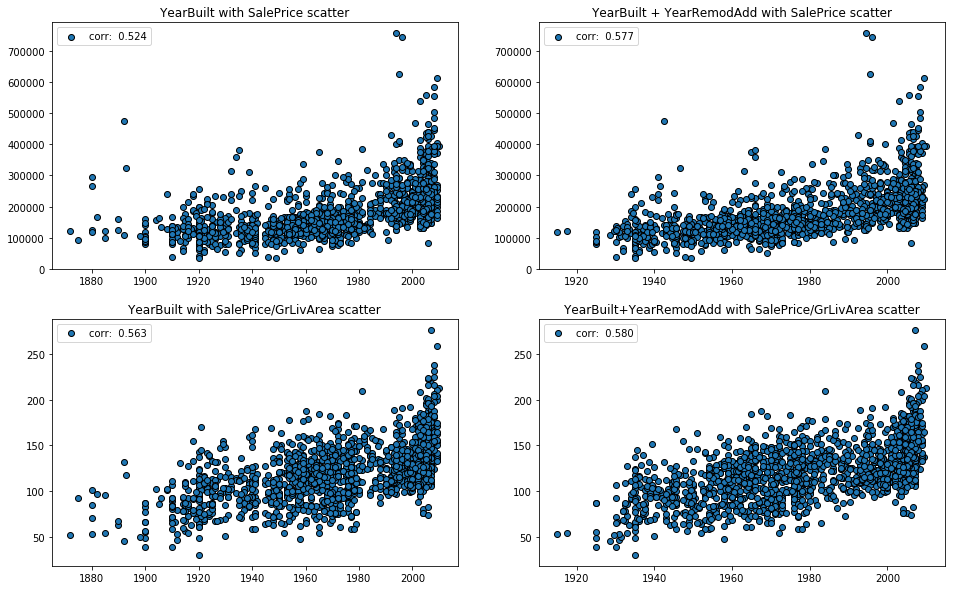

In [7]:
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.scatter(training['YearBuilt'], training['SalePrice'], edgecolors='k')
plt.title('YearBuilt with SalePrice scatter')
plt.legend(['corr: % .3f' % np.corrcoef(training['YearBuilt'], training['SalePrice'])[0,1]])

plt.subplot(2,2,2)
plt.scatter(training['YearBuilt']*0.5 + training['YearRemodAdd']*0.5, training['SalePrice'], edgecolors='k')
plt.title('YearBuilt + YearRemodAdd with SalePrice scatter')
plt.legend(['corr: % .3f' % np.corrcoef(training['YearBuilt']*0.5 + training['YearRemodAdd']*0.5, training['SalePrice'])[0,1]])

plt.subplot(2,2,3)
plt.scatter(training['YearBuilt'], training['SalePrice']/training['GrLivArea'], edgecolors='k')
plt.title('YearBuilt with SalePrice/GrLivArea scatter')
plt.legend(['corr: % .3f' % np.corrcoef(training['YearBuilt'], training['SalePrice']/training['GrLivArea'])[0,1]])

plt.subplot(2,2,4)
plt.scatter(training['YearBuilt']*0.5 + training['YearRemodAdd']*0.5, training['SalePrice']/training['GrLivArea'], edgecolors='k')
plt.title('YearBuilt+YearRemodAdd with SalePrice/GrLivArea scatter')
plt.legend(['corr: % .3f' % np.corrcoef(training['YearBuilt']*0.5 + training['YearRemodAdd']*0.5, training['SalePrice']/training['GrLivArea'])[0,1]])


plt.show()

而在房屋建造年份('YearBuilt')和房價的關係上，即使加上了翻修年份('YearRemodAdd')仍然有些觀察值是偏離主群體的，但是我們將房價除以居住面積後，拿得到的每平方英寸的房價和房屋年份比較後，就可以將偏離的狀況消除，並且維持一定的關聯性，因此在對房屋年份的部分就不進行離群值的處理。在後面，我們或許可以創造一個由建造年份和翻修年份組合的新特徵。

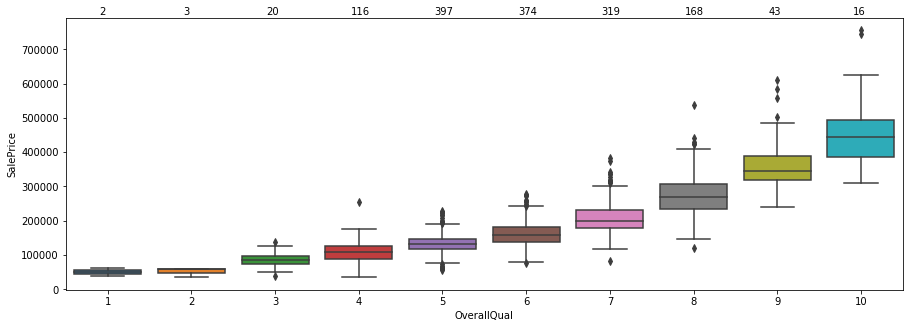

In [8]:
plt.figure(figsize=(15,5))
sns.boxplot(training['OverallQual'].sort_values(), training['SalePrice'])
for i in range(0, training['OverallQual'].nunique()):
    plt.text(i-0.1, 800000, '%s' % training['OverallQual'].value_counts().sort_index()[i+1])
plt.show()

再來看到房價('SalePrice')和房屋品質('OverallQual')的關係，由於和房屋品質的類別只有10類，因此我把它當成類別變項，使用boxplot來呈現，其中頂端的數字為每個分類的觀察值次數，可以看到一、二類的觀察次數過少，可能不具有代表意義。處此之外，房屋品質的整體趨勢呈現逐漸上升的情況。

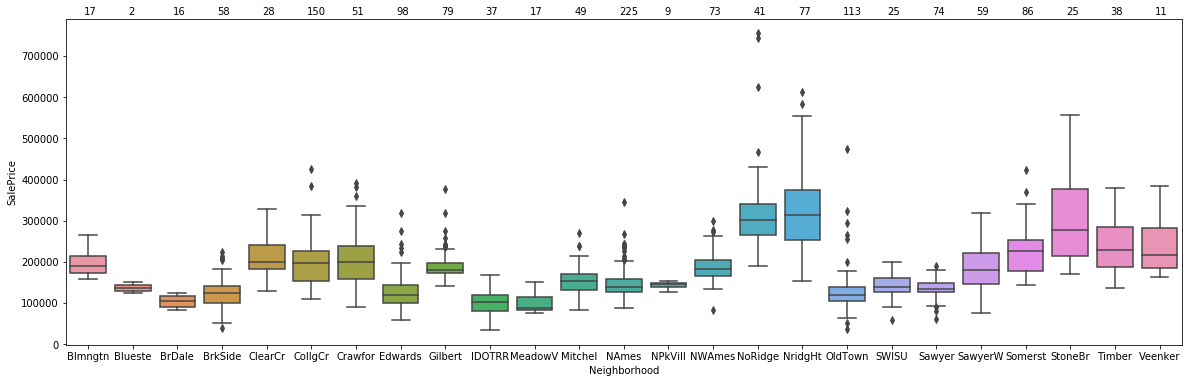

In [9]:
plt.figure(figsize=(20,6))
sns.boxplot(training['Neighborhood'].sort_values(), training['SalePrice'])
for i in range(0, training['Neighborhood'].nunique()):
    plt.text(i-0.1, 800000, '%s' % training['Neighborhood'].value_counts().sort_index()[i])
plt.show()
    
#training['Neighborhood'].value_counts().sort_index()[1]


接著讓我們看到鄰里('Neighborhood')的影響。同樣，在頂端的數字代表著鄰里各類別所觀察到的次數。看起來房價在不同鄰里的變化也是相當巨大。

最後讓我們回到目標變項，再一次的關注'SalePrice'。這次只單對'SalePrice'進行調整，我們將把'SalePrice'的分布調成到近似常態分配。  
在原始資料的'SalePrice'是一個右偏的分布。透過log轉換，通常可以對右偏態做出不錯的轉換效果，這邊我們也對'SalePrice'進行log轉換。可以看到，在對'SalePrice'做出log轉換後，偏態和峰度都更趨近於0，常態機率圖也比未做轉換的原始分佈漂亮。

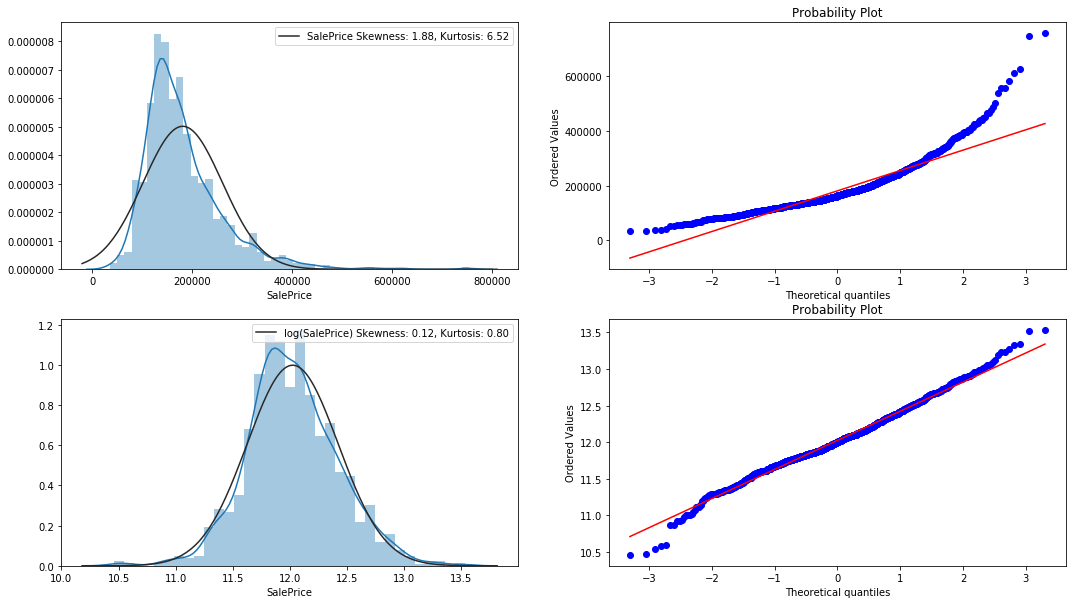

In [10]:
from scipy import stats
fig = plt.figure(figsize=(18,10))
plt.subplot(2,2,1) 
sns.distplot(training['SalePrice'], fit=stats.norm)
plt.legend(['SalePrice Skewness: {0:0.2f}, Kurtosis: {1:0.2f}'.format(training['SalePrice'].skew(), training['SalePrice'].kurt())])
plt.subplot(2,2,2) 
res = stats.probplot(training['SalePrice'], plot=plt)
plt.subplot(2,2,3) 
sns.distplot(np.log1p(training['SalePrice']), fit=stats.norm)
plt.legend(['log(SalePrice) Skewness: {0:0.2f}, Kurtosis: {1:0.2f}'.format(np.log1p(training['SalePrice']).skew(), np.log1p(training['SalePrice']).kurt())])
plt.subplot(2,2,4) 
res = stats.probplot(np.log1p(training['SalePrice']), plot=plt)
plt.show()

## 2. 特徵工程

到此，我們已經大致瀏覽過一遍數據了，也對較為重要的特徵有深度的瞭解。再來我們將對每個特徵進行"再造"。  
首先要做的是遺漏值差補，在差補遺漏值之前我們必須先了解遺漏的意義。這裡的資料其實有多遺漏值並不代表沒有資料，而是這些房子沒有這些設施，此時的差補做法就應該是新增一個類別為'None'或對於數值型態的資料則直接補'0'，而不是差補眾數、中位數、平均數這些統計量。  
在進行差補之前，我們先把訓練集資料和測試及資料合併。

In [11]:
ntrain = training.shape[0] 
ntest = testing.shape[0]
y_train = training['SalePrice'].values 
full_data = pd.concat([training, testing], ignore_index=True)
full_data = full_data.drop(['SalePrice'], axis=1)
print("full_data shape is : {}".format(full_data.shape))

full_data shape is : (2917, 80)


In [12]:
#missing data
total = full_data.isnull().sum().sort_values(ascending=False)
percent = (full_data.isnull().sum()/full_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.loc[missing_data['Total']!=0]

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageQual,159,0.054508
GarageFinish,159,0.054508
GarageYrBlt,159,0.054508
GarageCond,159,0.054508


In [13]:
# Alley: 不是真的遺漏，代表房屋不在巷弄中
full_data.loc[:, "Alley"] = full_data.loc[:, "Alley"].fillna("No")
# PoolQC: 不是真的遺漏，代表房屋沒有泳池
full_data.loc[:, "PoolQC"] = full_data.loc[:, "PoolQC"].fillna("No")
# MiscFeature: 遺漏值代表沒有雜項特徵
full_data.loc[:, "MiscFeature"] = full_data.loc[:, "MiscFeature"].fillna("No")
# Fence: 不是真的遺漏，代表房屋沒有柵欄
full_data.loc[:, "Fence"] = full_data.loc[:, "Fence"].fillna("No")
# FireplaceQu: 不是真的遺漏，代表房屋沒有壁爐
full_data.loc[:, "FireplaceQu"] = full_data.loc[:, "FireplaceQu"].fillna("No")


在車庫資訊的遺漏值中，遺漏也很有可能代表著房屋沒有車庫，但'GarageType'比其他相關資訊多了兩筆資料，因此我們先看只有'GarageType'，沒有其他車庫資訊的觀察值。在這兩筆觀察值中的遺漏值就很有可能是真的遺漏數據，而不是沒有車庫，因此對於這兩筆資料的遺漏值我將選擇填入屬於同樣'GarageType'('Detchd')的眾數或是中位數。  


In [14]:
# Garage: 檢視GarageTypec和其他Garagey資料的遺漏值差別
Garage = ['GarageQual','GarageFinish','GarageYrBlt','GarageCond','GarageType','GarageCars','GarageArea']
full_data.loc[full_data['GarageQual'].isnull()&full_data['GarageType'].notnull(), Garage].head()

,GarageQual,GarageFinish,GarageYrBlt,GarageCond,GarageType,GarageCars,GarageArea
2124,NaN,NaN,NaN,NaN,Detchd,1.0,360.0
2574,NaN,NaN,NaN,NaN,Detchd,NaN,NaN


In [15]:
# 使用GarageType==Detchd的眾數填補將2124,2574兩筆資料
full_data.loc[[2124,2574],'GarageQual'] = full_data.loc[full_data['GarageType']=='Detchd',:].loc[full_data['GarageQual'].notnull(),'GarageQual'].mode()[0]
full_data.loc[[2124,2574],'GarageFinish'] = full_data.loc[full_data['GarageType']=='Detchd',:].loc[full_data['GarageFinish'].notnull(),'GarageFinish'].mode()[0]
full_data.loc[[2124,2574],'GarageCond'] = full_data.loc[full_data['GarageType']=='Detchd',:].loc[full_data['GarageCond'].notnull(),'GarageCond'].mode()[0]
full_data.loc[[2124,2574],'GarageYrBlt'] = full_data.loc[full_data['GarageType']=='Detchd',:].loc[full_data['GarageYrBlt'].notnull(),'GarageYrBlt'].median()
# 使用GarageType==Detchd的中位數填補GarageArea和GarageCars的遺漏值
full_data.loc[2574, "GarageArea"] = full_data.loc[full_data['GarageType']=='Detchd',:].loc[full_data['GarageArea'].notnull(),'GarageArea'].median()
full_data.loc[2574, "GarageCars"] = full_data.loc[full_data['GarageType']=='Detchd',:].loc[full_data['GarageCars'].notnull(),'GarageCars'].median()
# 其他遺漏值代表沒有車庫
full_data.loc[:, "GarageQual"] = full_data.loc[:, "GarageQual"].fillna("No")
full_data.loc[:, "GarageFinish"] = full_data.loc[:, "GarageFinish"].fillna("No")
full_data.loc[:, "GarageCond"] = full_data.loc[:, "GarageCond"].fillna("No")
full_data.loc[:, "GarageYrBlt"] = full_data.loc[:, "GarageYrBlt"].fillna(0)
full_data.loc[:, "GarageType"] = full_data.loc[:, "GarageType"].fillna("No")

In [16]:
# Bsmt: 先處理地下室面積為0代表房屋沒有地下室
full_data.loc[full_data['TotalBsmtSF']==0 & \
full_data['BsmtCond'].isnull() & \
full_data['BsmtQual'].isnull(), ['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType1','BsmtFinType2']] = 'No'

In [17]:
Bsmt = ['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType1','BsmtFinType2','BsmtFullBath','BsmtHalfBath','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF']
full_data.loc[full_data['BsmtFullBath'].isnull(),Bsmt].head()

,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF
2118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2186,No,No,No,No,No,NaN,NaN,0.0,0.0,0.0,0.0


In [18]:
# 先處理完全沒有地下室資訊的觀察值，當成沒有地下室，補上'None'或'0'
full_data.loc[2118, ['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType1','BsmtFinType2']] = 'No'
full_data.loc[2118, ['BsmtFullBath','BsmtHalfBath','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF']] = 0
full_data.loc[2186, ['BsmtFullBath','BsmtHalfBath']] = 0

In [19]:
# 處理'BsmtCond'的遺漏值
full_data.loc[full_data['BsmtCond'].isnull(),Bsmt].head()

,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF
2038,NaN,Mn,Gd,GLQ,Rec,1.0,0.0,0.0,1044.0,382.0,1426.0
2183,NaN,No,TA,BLQ,Unf,0.0,1.0,94.0,1033.0,0.0,1127.0
2522,NaN,Av,TA,ALQ,Unf,0.0,0.0,240.0,755.0,0.0,995.0


In [20]:
print(full_data['BsmtCond'].value_counts())
# 由於'BsmtCond'的眾數差異很大，這邊直接使用眾數代替
full_data.loc[:, "BsmtCond"] = full_data.loc[:, "BsmtCond"].fillna(full_data['BsmtCond'].mode()[0])

TA    2604
Gd     122
Fa     104
No      79
Po       5
Name: BsmtCond, dtype: int64


In [21]:
# 處理'BsmtExposure'的遺漏值
full_data.loc[full_data['BsmtExposure'].isnull(),Bsmt].head()

,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF
947,TA,NaN,Gd,Unf,Unf,0.0,0.0,936.0,0.0,0.0,936.0
1485,TA,NaN,Gd,Unf,Unf,0.0,0.0,1595.0,0.0,0.0,1595.0
2346,TA,NaN,Gd,Unf,Unf,0.0,0.0,725.0,0.0,0.0,725.0


In [22]:
print(full_data['BsmtExposure'].value_counts())
# 由於'BsmtCond'的眾數差異很大，這邊直接使用眾數代替
full_data.loc[:, "BsmtExposure"] = full_data.loc[:, "BsmtExposure"].fillna(full_data['BsmtExposure'].mode()[0])

No    1983
Av     418
Gd     274
Mn     239
Name: BsmtExposure, dtype: int64


In [23]:
# 處理'BsmtQual'的遺漏值
full_data.loc[full_data['BsmtQual'].isnull(),Bsmt].head()

,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF
2215,Fa,No,NaN,Unf,Unf,0.0,0.0,173.0,0.0,0.0,173.0
2216,TA,No,NaN,Unf,Unf,0.0,0.0,356.0,0.0,0.0,356.0


In [24]:
# 'BsmtQual'眾數差異不大，因此使用隨機森林來做預測，將有遺漏值的特徵做為目標對象，可能與目標對象有關係的其他特徵做為預測變項。
BsmtQual = pd.get_dummies(full_data.loc[:, ['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtUnfSF','BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF']], prefix=['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'])
X = BsmtQual.drop([2215,2216])
y = full_data.loc[full_data['BsmtQual'].notnull(),'BsmtQual']
dtc = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=312)
dtc.fit(X, y)
dtc.predict(BsmtQual.iloc[[2215,2216]])

array(['Fa', 'Gd'], dtype=object)

In [25]:
pd.DataFrame(confusion_matrix(y, dtc.predict(X), labels=y.unique().tolist()), columns=y.unique().tolist())

,Gd,TA,Ex,No,Fa
0,1176,29,1,0,3
1,23,1258,0,0,2
2,0,4,252,0,0
3,0,0,0,79,0
4,2,11,0,0,75


In [26]:
# 補上'BsmtQual'的遺漏值 
full_data.loc[2215, 'BsmtQual'] = 'Fa'
full_data.loc[2216, 'BsmtQual'] = 'Gd'

In [27]:
# MasVnrType : 將Masonry veneer type改為None, Masonry veneer Area改為0
full_data.loc[:, "MasVnrType"] = full_data.loc[:, "MasVnrType"].fillna("No")
full_data.loc[:, "MasVnrArea"] = full_data.loc[:, "MasVnrArea"].fillna(0)

In [28]:
# MSZoning: MSZoning可能會和Neighborhood有關聯，因此這邊的策略是找出MSZoning的遺漏值在Neighborhood中的眾數，並取代之
full_data.loc[full_data['MSZoning'].isnull(), 'Neighborhood']

1913     IDOTRR
2214     IDOTRR
2248     IDOTRR
2902    Mitchel
Name: Neighborhood, dtype: object

In [29]:
print(full_data.loc[full_data['Neighborhood']=='IDOTRR', 'MSZoning'].mode())
print(full_data.loc[full_data['Neighborhood']=='Mitchel', 'MSZoning'].mode())

0    RM
dtype: object
0    RL
dtype: object


In [30]:
full_data.loc[[1913,2214,2248], 'MSZoning'] = 'RM'
full_data.loc[2902, 'MSZoning'] = 'RL'

In [31]:
# Utilities:使用眾數填補遺漏值
full_data.loc[:, "Utilities"] = full_data.loc[:, "Utilities"].fillna(full_data['Utilities'].mode()[0])
#Functional:使用眾數填補遺漏值
full_data.loc[:, "Functional"] = full_data.loc[:, "Functional"].fillna(full_data['Functional'].mode()[0])
#Exterior:使用眾數填補遺漏值
full_data.loc[:, "Exterior1st"] = full_data.loc[:, "Exterior1st"].fillna(full_data['Exterior1st'].mode()[0])
full_data.loc[:, "Exterior2nd"] = full_data.loc[:, "Exterior2nd"].fillna(full_data['Exterior2nd'].mode()[0])
#Electrical:使用眾數填補遺漏值
full_data.loc[:, "Electrical"] = full_data.loc[:, "Electrical"].fillna(full_data['Electrical'].mode()[0])
#SaleType:使用眾數填補遺漏值
full_data.loc[:, "SaleType"] = full_data.loc[:, "SaleType"].fillna(full_data['SaleType'].mode()[0])
#SaleType:使用眾數填補遺漏值
full_data.loc[:, "KitchenQual"] = full_data.loc[:, "KitchenQual"].fillna(full_data['KitchenQual'].mode()[0])
#BsmtFinType2:這邊有一筆地下室面積不為0，但卻有遺漏值的資料，使用眾數填補
full_data.loc[:, "BsmtFinType2"] = full_data.loc[:, "BsmtFinType2"].fillna(full_data['BsmtFinType2'].mode()[0])

In [32]:
# LotArea_sqrt:使用LotArea, Neighborhood, MSZoning來預估LotFrontage
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
D = full_data[['LotFrontage','LotArea','Neighborhood','MSZoning']]
D['LotArea'] = np.log1p(D['LotArea'])
D = pd.get_dummies(D)
X = D.loc[D['LotFrontage'].notnull()].drop('LotFrontage', axis=1)
y = D.loc[full_data['LotFrontage'].notnull(),'LotFrontage']
## xgboostRegression
xgbm = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, 
                    subsample=0.8, random_state = 312, nthread = -1)
xgbm.fit(X, np.log1p(y))
xgb_score = cross_val_score(xgbm, X, np.log1p(y), scoring='neg_mean_squared_error', cv = KFold(5, True, 312), n_jobs=-1)
print(-xgb_score)
print(np.mean((np.log1p(y) - xgbm.predict(X))**2))
print('''mean of xgboost model: %f
std of xgboost model: %f''' %(-xgb_score.mean(), xgb_score.std()))
## RandomForestRegressor
rf = RandomForestRegressor(500, n_jobs=-1, random_state=312)
rf.fit(X, np.log1p(y))
rf_score = cross_val_score(rf, X, np.log1p(y), scoring='neg_mean_squared_error', cv = KFold(5, True, 312), n_jobs=-1)
print(-rf_score)
print(np.mean((np.log1p(y) - rf.predict(X))**2))
print('''mean of randomforest model: %f
std of randomforest model: %f''' %(-rf_score.mean(), rf_score.std()))
# 採用xgboost的結果
model_X = D.loc[D['LotFrontage'].isnull()].drop('LotFrontage', axis=1)
pred_X = xgbm.predict(model_X)

D:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


[ 0.03481566  0.03867299  0.04622204  0.03334928  0.03371888]
0.018124912695974337
mean of xgboost model: 0.037356
std of xgboost model: 0.004818
[ 0.0367632   0.04058039  0.04470759  0.04057682  0.03380457]
0.006253903449432597
mean of randomforest model: 0.039287
std of randomforest model: 0.003719


In [33]:
for i, index in enumerate(np.where(full_data['LotFrontage'].isnull())[0]):
    full_data.loc[index, 'LotFrontage'] = np.exp(pred_X)[i]-1

In [34]:
# check missing data
total = full_data.isnull().sum().sort_values(ascending=False)
percent = (full_data.isnull().sum()/full_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.loc[missing_data['Total']!=0]

,Total,Percent


在前面，我們發現建造年份和翻修年份會和房價有關聯，而且合在一起看的關聯性比單獨看好。因此我們將新增一個有關建造年份和翻修年份的特徵。

In [35]:
full_data["Yr_blt_remod"] = full_data["YearBuilt"]*0.5 + full_data["YearRemodAdd"]*0.5
full_data["AllSF"] = full_data["GrLivArea"] + full_data["TotalBsmtSF"]

接著我們將拆分連續變項和類別變項，分別要進行log轉移和製作虛擬變項。

In [36]:
# 將原始資料為數值型態，但卻有'None'或是是類別分類的特徵轉為類別變項
to_categorical = ['BedroomAbvGr','BsmtFullBath','BsmtHalfBath','OverallQual', 'OverallCond','Fireplaces','FullBath','GarageCars','HalfBath',
'KitchenAbvGr','MSSubClass','MoSold','YrSold']

for c in to_categorical:
    full_data[c] = full_data[c].apply(str)
    
categorical_features = full_data.select_dtypes(include = ["object"]).columns
numerical_features = full_data.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

Numerical features : 26
Categorical features : 56


檢視連續變項的偏態，並將絕對值大於0.75的特徵進行log轉移

In [37]:
from scipy.stats import norm, skew
skewed_feats = full_data[numerical_features].apply(lambda x: x.dropna().skew()).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

,Skew
MiscVal,21.950962
PoolArea,17.697766
LotArea,13.116240
LowQualFinSF,12.090757
3SsnPorch,11.377932
BsmtFinSF2,4.146636
EnclosedPorch,4.004404
ScreenPorch,3.947131
MasVnrArea,2.623068
OpenPorchSF,2.530660


In [38]:
full_data[skewness[np.abs(skewness['Skew']) > 0.75].index] = np.log1p(full_data[skewness[np.abs(skewness['Skew']) > 0.75].index])

In [39]:
print(pd.get_dummies(full_data.drop('Id', axis=1)).shape)

(2917, 380)


## 3. 建模

我們開市進入建模階段，這邊我們分別使用random forest, xgboost, LASSO來對資料建模。而在比較模型預測能力的方法我們使用kflod的方法來進行交叉驗證，比較在十個資料及的預測能力平均數和標準差。並且畫出預測結果和實際值的差異圖以及每個模型的特徵重要性排序。  
*注意：*這邊三個模型的特徵重要程度係數不能互相比較，因為彼此代表的意涵不一樣，模型間只能比較特徵重要的排序。排序前面的特徵代表對於該模型的重要程度越高。

In [77]:
kf = KFold(n_splits=10, shuffle=True, random_state=312)

In [415]:
rf = RandomForestRegressor(500, max_features=370//3, n_jobs=-1, random_state=312)
plot_validation_true_y = []
plot_validation_pred_y = []
scores = []
scl = StandardScaler()
for i, (train_index, test_index) in enumerate(kf.split(train_data)):
    X = scl.fit_transform(train_data.loc[train_index])
    train_true_y = np.log1p(y_train[train_index])
    validation_true_y = np.log1p(y_train[test_index])
    rf.fit(X, train_true_y)
    validation_pred_y = rf.predict(scl.transform(train_data.loc[test_index]))
    plot_validation_true_y = np.concatenate((plot_validation_true_y, np.array(validation_true_y)),0)
    plot_validation_pred_y = np.concatenate((plot_validation_pred_y, validation_pred_y),0)
    score = np.sqrt(mean_squared_error(validation_true_y, validation_pred_y))
    scores = scores + [score]
    print("[fold {0}] RSME: {1:.5f}".format(i+1, score),)
print("RandomForest score: {:.4f} ({:.4f})".format(np.mean(scores),np.std(scores)))

[fold 1] RSME: 0.15552
[fold 2] RSME: 0.13140
[fold 3] RSME: 0.11591
[fold 4] RSME: 0.12322
[fold 5] RSME: 0.13631
[fold 6] RSME: 0.12318
[fold 7] RSME: 0.14482
[fold 8] RSME: 0.12816
[fold 9] RSME: 0.13887
[fold 10] RSME: 0.15581
RandomForest score: 0.1353 (0.0129)


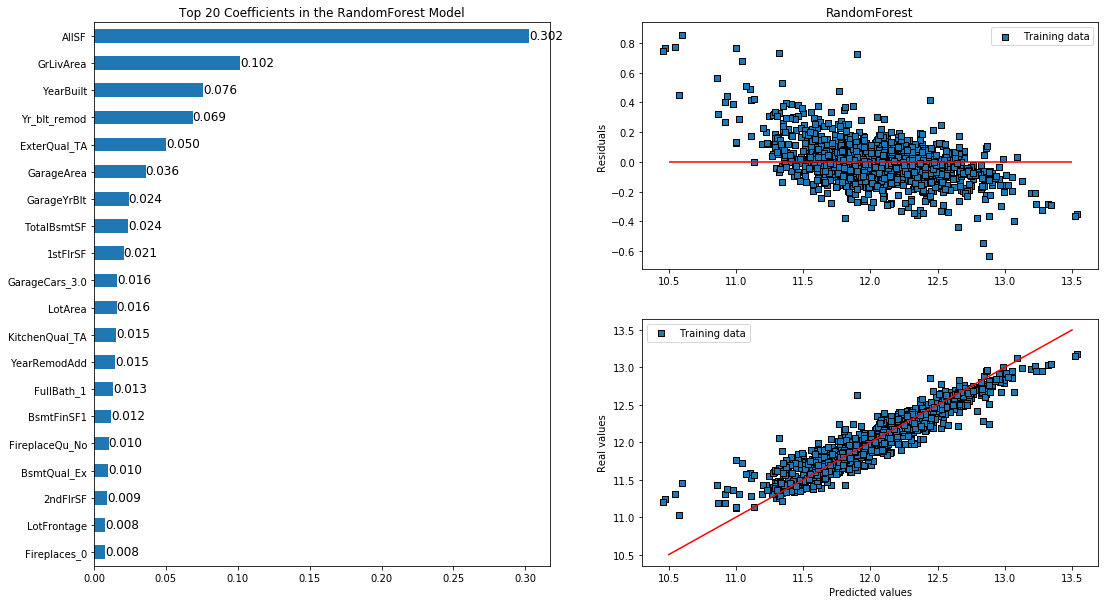

In [416]:
plt.figure(figsize=(18, 10))
gs = GridSpec(2, 2)
plt.subplot(gs[0,1])
plt.scatter(plot_validation_true_y, plot_validation_pred_y - plot_validation_true_y, label = "Training data", edgecolors='k', marker='s')
plt.title("RandomForest")
plt.ylabel("Residuals")
plt.legend(loc = "upper right")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

# Plot predictions
plt.subplot(gs[1,1])
plt.scatter(plot_validation_true_y, plot_validation_pred_y,  label = "Training data", edgecolors='k', marker='s')
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

plt.subplot(gs[0:,0])
coefs = pd.DataFrame([rf.feature_importances_, np.abs(rf.feature_importances_)], columns= train_data.columns, index=['coef','abs']).T
imp_coefs = coefs.sort_values(['abs'], ascending=True).tail(20)
imp_coefs['coef'].plot(kind='barh')
plt.title("Top 20 Coefficients in the RandomForest Model")
for i in range(0,20):
    if imp_coefs['coef'][i] < 0:
        plt.text(imp_coefs['coef'][i], i-0.1, '%0.3f' % imp_coefs['coef'][i], fontsize=12, color='k')
    else:
        plt.text(imp_coefs['coef'][i], i-0.1, '%0.3f' % imp_coefs['coef'][i], fontsize=12, color='k')
plt.show()

In [ ]:
從隨機森林的結果可以看到，對房價做出預測的結果會比對角線(準確預測)還要傾斜，也就是說，在預測昂貴的房屋時會高估，在預測便宜的房屋時則會低估

In [409]:
xgbm = xgb.XGBRegressor(max_depth=4,learning_rate=0.05,n_estimators=800,n_jobs=-1,subsample=0.9, colsample_bytree=0.6,random_state=312)
plot_validation_true_y = []
plot_validation_pred_y = []
scores = []
scl = StandardScaler()
for i, (train_index, test_index) in enumerate(kf.split(train_data)):
    X = scl.fit_transform(train_data.loc[train_index])
    train_true_y = np.log1p(y_train[train_index])
    validation_true_y = np.log1p(y_train[test_index])
    xgbm.fit(X, train_true_y)
    validation_pred_y = xgbm.predict(scl.transform(train_data.loc[test_index]))
    plot_validation_true_y = np.concatenate((plot_validation_true_y, np.array(validation_true_y)),0)
    plot_validation_pred_y = np.concatenate((plot_validation_pred_y, validation_pred_y),0)
    score = np.sqrt(mean_squared_error(validation_true_y, validation_pred_y))
    scores = scores + [score]
    print("[fold {0}] RSME: {1:.5f}".format(i+1, score),)
print("xgboost score: {:.4f} ({:.4f})".format(np.mean(scores),np.std(scores)))

[fold 1] RSME: 0.13497
[fold 2] RSME: 0.10970
[fold 3] RSME: 0.10073
[fold 4] RSME: 0.10746
[fold 5] RSME: 0.12557
[fold 6] RSME: 0.10817
[fold 7] RSME: 0.11469
[fold 8] RSME: 0.11320
[fold 9] RSME: 0.12940
[fold 10] RSME: 0.13034
RandomForest score: 0.1174 (0.0111)


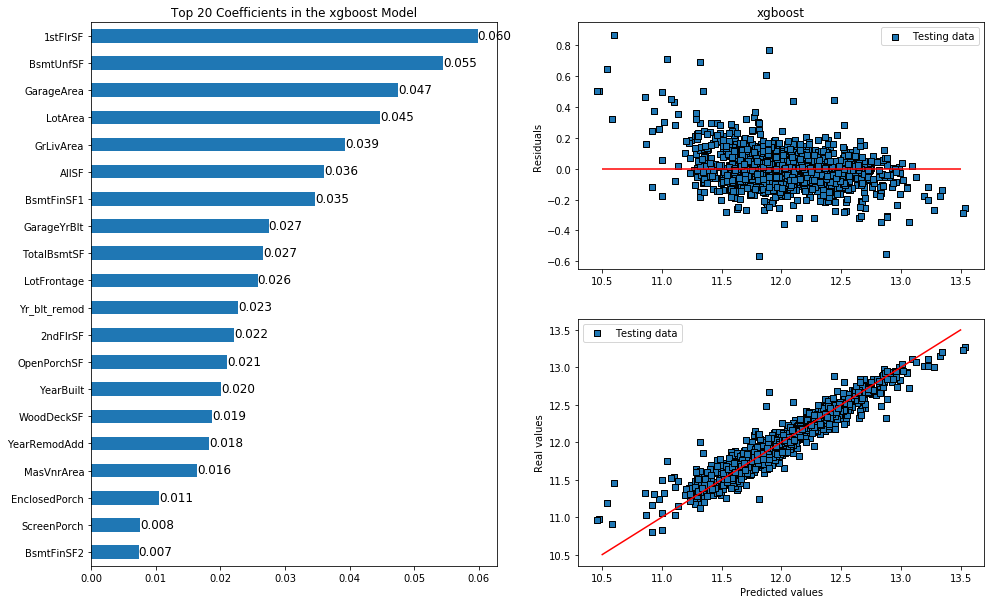

In [410]:
plt.figure(figsize=(16,10))
gs = GridSpec(2, 2)
plt.subplot(gs[0,1])
plt.scatter(plot_validation_true_y, plot_validation_pred_y - plot_validation_true_y, label = "Testing data", edgecolors='k', marker='s')
plt.title("xgboost")
plt.ylabel("Residuals")
plt.legend(loc = "upper right")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

# Plot predictions
plt.subplot(gs[1,1])
plt.scatter(plot_validation_true_y, plot_validation_pred_y,  label = "Testing data", edgecolors='k', marker='s')
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

plt.subplot(gs[0:,0])
coefs = pd.DataFrame([xgbm.feature_importances_, np.abs(xgbm.feature_importances_)], columns= train_data.columns, index=['coef','abs']).T
imp_coefs = coefs.sort_values(['abs'], ascending=True).tail(20)
imp_coefs['coef'].plot(kind='barh')
plt.title("Top 20 Coefficients in the xgboost Model")
for i in range(0,20):
    if imp_coefs['coef'][i] < 0:
        plt.text(imp_coefs['coef'][i], i-0.1, '%0.3f' % imp_coefs['coef'][i], fontsize=12, color='k')
    else:
        plt.text(imp_coefs['coef'][i], i-0.1, '%0.3f' % imp_coefs['coef'][i], fontsize=12, color='k')
plt.show()

xgboost模型的交叉驗證結果比較好，在平均數上和標準差上都是。但在特徵的重要排序上，和隨機森林模型就有差異，對xgboost模型來說，一樓的面積是最重要的特徵，而房屋的全部面積則排在第五順位。這和隨機森林模型是比較大的不同。

Computing regularization path using the coordinate descent lasso...


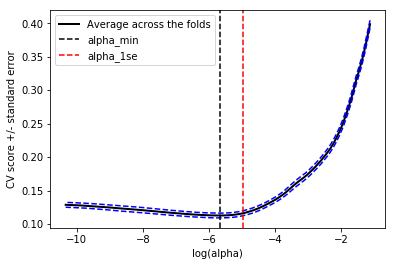

training time: 12.75
alpha_min: 0.003487 
alpha_1se: 0.006982


In [95]:
scl = StandardScaler()
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
X = scl.fit_transform(train_data)
y = np.log1p(y_train)
cv = KFold(n_splits=10, shuffle=True)
n_alphas = 200
L_model = LassoCV(eps=0.0001, n_alphas=n_alphas, cv=cv, max_iter=10000, n_jobs=-1).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = np.log(L_model.alphas_)

plt.figure()
L_model_rmse = np.sqrt(L_model.mse_path_).mean(axis=-1)
L_model_se = np.sqrt(L_model.mse_path_).std(axis=-1) / np.sqrt(cv.n_splits)

plt.plot(m_log_alphas, L_model_rmse, 'k', label='Average across the folds', linewidth=2)
plt.plot(m_log_alphas, L_model_rmse + L_model_se, 'b--')
plt.plot(m_log_alphas, L_model_rmse - L_model_se, 'b--')

#np.column_stack(L_model_rmse, L_model.alphas_)
L_model_alpha_min = float(L_model.alphas_[np.argwhere(L_model_rmse == L_model_rmse.min())])
L_model_info = np.column_stack((np.arange(n_alphas), L_model_rmse, L_model.alphas_, L_model_se))
a = np.where(L_model_info==L_model_info[:,1].min())[0][0] # rsme最小值的index
b = np.where((L_model_info[:,1] <= L_model_info[a,1] + L_model_info[a,3]) & (L_model_info[:,0] <= a)) # 小於一個最小rmse一個SE之間，且，大於最小rmse的index
c = np.where(L_model_info == L_model_info[b,1].max())[0][0] # 小於一個最小rmse一個SE之間，且，大於最小rmse的最大值
L_model_alpha_1se = L_model_info[c, 2]
plt.axvline(np.log(L_model_alpha_min), linestyle='--', color='k', label='alpha_min')
plt.axvline(np.log(L_model_alpha_1se), linestyle='--', color='red', label='alpha_1se')

plt.legend()
plt.xlabel('log(alpha)')
plt.ylabel('CV score +/- standard error')
plt.axis('tight')
plt.show()
print('training time: {0:.2f}'.format(t_lasso_cv))
print('alpha_min: {0:0.6f} \nalpha_1se: {1:0.6f}'.format(L_model_alpha_min, L_model_alpha_1se))

In [96]:
lasso_m = Lasso(alpha=L_model_alpha_min, random_state=312)
plot_validation_true_y = []
plot_validation_pred_y = []
scores = []
scl = StandardScaler()
for i, (train_index, test_index) in enumerate(kf.split(train_data)):
    X = scl.fit_transform(train_data.loc[train_index])
    train_true_y = np.log1p(y_train[train_index])
    validation_true_y = np.log1p(y_train[test_index])
    lasso_m.fit(X, train_true_y)
    validation_pred_y = lasso_m.predict(scl.transform(train_data.loc[test_index]))
    plot_validation_true_y = np.concatenate((plot_validation_true_y, np.array(validation_true_y)),0)
    plot_validation_pred_y = np.concatenate((plot_validation_pred_y, validation_pred_y),0)
    score = np.sqrt(mean_squared_error(validation_true_y, validation_pred_y))
    scores = scores + [score]
    print("[fold {0}] RSME: {1:.5f}".format(i+1, score),)
print("Lasso score: {:.4f} ({:.4f})".format(np.mean(scores),np.std(scores)))

[fold 1] RSME: 0.13367
[fold 2] RSME: 0.09804
[fold 3] RSME: 0.08587
[fold 4] RSME: 0.11928
[fold 5] RSME: 0.11202
[fold 6] RSME: 0.10412
[fold 7] RSME: 0.12188
[fold 8] RSME: 0.09667
[fold 9] RSME: 0.12638
[fold 10] RSME: 0.12148
Lasso score: 0.1119 (0.0145)


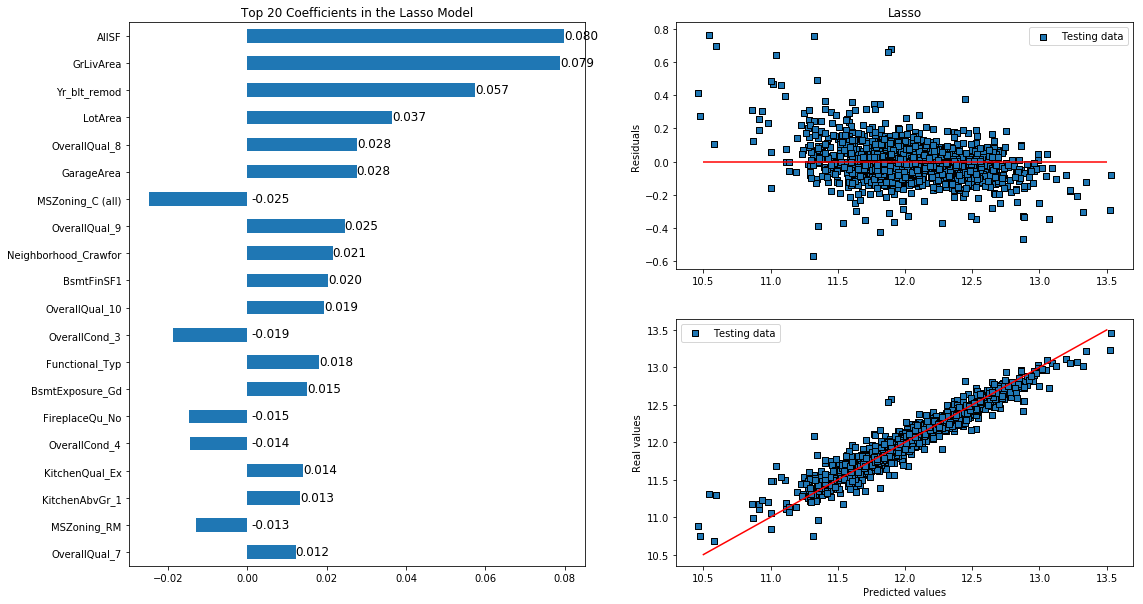

Lasso picked 138 features


In [97]:
plt.figure(figsize=(18, 10))
gs = GridSpec(2, 2)
plt.subplot(gs[0,1])
plt.scatter(plot_validation_true_y, plot_validation_pred_y - plot_validation_true_y, label = "Testing data", edgecolors='k', marker='s')
plt.title("Lasso")
plt.ylabel("Residuals")
plt.legend(loc = "upper right")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
#plt.show()
# Plot predictions
plt.subplot(gs[1,1])
plt.scatter(plot_validation_true_y, plot_validation_pred_y,  label = "Testing data", edgecolors='k', marker='s')
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
#plt.show()


plt.subplot(gs[0:,0])
coefs = pd.DataFrame([lasso_m.coef_, np.abs(lasso_m.coef_)], columns= train_data.columns, index=['coef','abs']).T
imp_coefs = coefs.sort_values(['abs'], ascending=True).tail(20)
imp_coefs['coef'].plot(kind='barh')
plt.title("Top 20 Coefficients in the Lasso Model")
for i in range(0,20):
    if imp_coefs['coef'][i] < 0:
        plt.text(0.001, i-0.1, '%0.3f' % imp_coefs['coef'][i], fontsize=12, color='k')
    else:
        plt.text(imp_coefs['coef'][i], i-0.1, '%0.3f' % imp_coefs['coef'][i], fontsize=12, color='k')
plt.show()
print("Lasso picked " + str(sum(coefs['coef'] != 0)) + " features")

最後我們嘗試了Lasso模型，再進行Lasso的建模之間前，為了找出關鍵參數懲罰項，我們透過LassoCV來找出alhpa，最佳的alpha為.0032(成為alpha_min)，而在一個標準誤內的最佳alpha則是.0069(稱為alpha_1se)。會呈現alpha_1se的結果是基於模型簡單化的原因，當alpha越大，則Lasso所選擇的特徵越少，對於泛化的表現可能會比較好。  
再來看到Lasso模型的結果，交叉驗證的結果也不錯，而在特徵選擇上，房屋全部面積('AllSF')和居住面積('GrLivArea')則是Lasso模型的優先選擇。

In [401]:
scl = StandardScaler()
X = scl.fit_transform(train_data)
train_true_y = np.log1p(y_train)
lasso_m.fit(X, train_true_y)
L_model_pred = np.expm1(lasso_m.predict(scl.transform(test_data)))

In [402]:
sub = pd.DataFrame()
sub['Id'] = testing['Id']
sub['SalePrice'] = L_model_pred
sub.to_csv('submission.csv',index=False)

## 4. 結語

在這次Ames的房價預估中，我們在一開始先綜覽了數據，了解每個特徵的型態，也試著想像出那些特徵和目標變項可能有重要的關係，對資料有了表面的認識，也透過統計量和圖表找出與目標變項有關的特徵，並刪除了兩個極度嚴重的outliers，之後也對'SalePrice'進行log轉換，使分布趨近常態。  
其次，在了解資料後，我們對遺漏值進行合理的差補，並非只要遇到遺漏值刪除資料或是直接用平均數來補，而是先判斷遺漏值所代表的意義，之後才用適合的統計量來差補。此外，我們新增了兩個特徵，分別是房子的全部面積，以及建造年份與翻修年份的加總。我們對連續型的特徵進行log轉換和標準化，以便後面建模時的分析。  
最後我們使用隨機森林、xgboost和Lasso來對資料進行預測，透過交叉驗證來比較這三個模型的預測能力。其中Lasso的交互驗證結果較佳。在特徵選取部分，三個模型的top20重要特徵都有選擇我們新增的全部面積('AllSF')和建造/翻修年份(Yr_blt_remdl)。  
最後Lasso模型在kaggle上的得分為0.12624，排名為704(25%)。